In [23]:
import pandas as pd
import numpy as np
# import seaborn as sns
from operator import attrgetter
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
# importing R dependencies
import rpy2
import readline
import rpy2.robjects as robjects

ImportError: No module named 'rpy2'

In [18]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [19]:
robjects.r('pi')

array([ 3.14159265])

In [22]:
%R require(ggplot2)

/home/mattreyes/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


array([0], dtype=int32)

In [14]:
robjects.r.array([1])

NameError: name 'robjects' is not defined

We begin with the following mixture model $f$
$$f(x) = \pi \phi(x|\mu_{1},\sigma_{1}^{2}) + (1-\pi)\phi(x|\mu_{2},\sigma_{2}^{2})$$

where $\pi \in [0,1]$.


Given a dataset of $n$ observations we have that the likelihood function is

$$
L(\mu_{1},\sigma_{1}^{2},\mu_{2},\sigma_{2}^{2}|x) = 
\prod_{i=1}^{n}[\pi\phi(x_{i}|\mu_{1},\sigma_{1}^{2}) + (1-\pi)\phi(x_{i}|\mu_{2},\sigma_{2}^{2})]
$$

# PSO Algorithm

In [24]:
class Particle:
    def __init__(self,position,velocity):
        self.position = position
        self.velocity = velocity
        self.pbest = position
        self.current_fitness = 0
        self.best_fitness = 0
        self.num_parameters = len(self.position)
    def update_position(self,gbest,
                        use_boundary=False,
                        lower_bound=None,
                        upper_bound=None):              
        c1 = 2
        c2 = 2
        r1 = np.random.rand(1)
        r2 = np.random.rand(1)
        delta = 2*r1*(self.pbest - self.position) + 2*r2*(gbest - self.position)
        
        upper_bound=np.zeros(self.num_parameters),
        lower_bound=np.zeros(self.num_parameters)
        
        cond1 = delta <= upper_bound
        cond2 = delta >= lower_bound
        
        if (use_boundary and cond1.all() and cond2.all()) or use_boundary==False:
            self.velocity = self.velocity + delta
            self.position = self.position + self.velocity
    def _phi(self,x,mean,var):
        k = math.sqrt(2*math.pi*var)
        p = math.exp((x-mean)*(x-mean)/(-2*var))
        return p/k
    def _mix_dist(self,x,pi,mean1,mean2,var1,var2):
        comp1 = pi*self._phi(x,mean1,var1)
        comp2 = (1-pi)*self._phi(x,mean2,var2)
        return comp1+comp2
    def _gaussian_likelihood(self,x,pi,mean1,mean2,var1,var2):
        # x is a vector of data
        n = len(x)
        p = 1
        for i in range(0,n):
            p = p * self._mix_dist(x[i],pi,mean1,mean2,var1,var2)
        return p
    def calculate_fitness(self,x,pi,mean1,mean2,var1,var2):
        self.current_fitness = self._gaussian_likelihood(x,pi,mean1,mean2,var1,var2)
        if self.current_fitness > self.best_fitness:
            self.pbest = self.position
            self.best_fitness = self.current_fitness

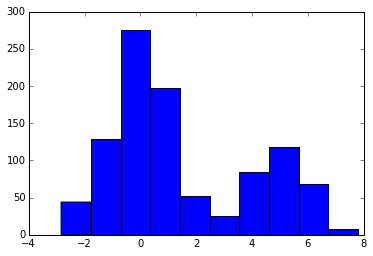

In [26]:
# Algorithm Parameters

N = 100
iterations = 50

a = np.random.normal(0,1,700)
b = np.random.normal(5,1,300)

x = np.concatenate((a,b),axis=0)

plt.hist(x)
plt.show()

data_min = min(x)
data_max = max(x)
lower_boundary = np.array([0,data_min,data_min,0,0])
upper_boundary = np.array([1,data_max,data_max,10,10])    
particles = [0] * N
tolerance = 0.001

In [28]:
# random intialization of particles

np.random.seed(69)

# estimating a weight parameter and mu parameter for each of the two gaussian components
# posn[0] = weight
# posn[1] = mu1
# posn[2] = mu2

for p in range(N):    
    rand_pi = np.random.uniform(0,1)
    rand_mean1 = np.random.uniform(data_min,data_max)
    rand_mean2 = np.random.uniform(data_min,data_max)
    sigma1 = 1
    sigma2 = 1
    rand_posn = np.array([rand_pi,rand_mean1,rand_mean2])
    rand_velocity = np.array([np.random.uniform(0,1),
                             np.random.uniform(0,1),
                             np.random.uniform(0,1)])
    
    particles[p] = Particle(rand_posn,rand_velocity)
    particles[p].calculate_fitness(x,rand_pi,rand_mean1,rand_mean2,sigma1,sigma2)

gbest = max(particles,key=attrgetter('best_fitness'))    

# repeat until convergence
for i in range(iterations):
    if i%100 == 0:
        print("iteration " + str(i))
    for p in particles:
        p.update_position(gbest.position,True,lower_boundary,upper_boundary)

        params = p.position
        pi = params[0]
        mean1 = params[1]
        mean2 = params[2]
        sigma1 = 1
        sigma2 = 1
        p.calculate_fitness(x,pi,mean1,mean2,sigma1,sigma2)
        gbest = max(particles,key=attrgetter('best_fitness'))    

print(gbest.pbest)
print(gbest.best_fitness)

iteration 0
[ 0.29624916  5.7695375   0.88493903]
0


In [ ]:
# next steps: 
# R generates data, passes to python
# add sigma parameters
# monte carlo: run algorithm multiple times 
# improve efficiency of likelihood calculation (mapreduce?)
# plot the estimated mixture densities vs kde for EM and PSO


# EM Algorithm

In [13]:
import math
import numpy as np
from matplotlib import pyplot as plt

def em(data,num_iter=10000):
    mu1 = 0
    mu2 = 0
    sd1 = 1
    sd2 = 1
    pi1 = 0.49
    pi2 = 1 - pi1
    n = len(data)
    
    def prob(x,mu,sd):
        nator = np.vectorize(math.exp)(((x-mu)*(x-mu))/(-2*sd*sd))
        dator = math.sqrt(2*math.pi)*sd
        return (nator/dator)
    def p1():
        return prob(data,mu1,sd1)
    def p2():
        return prob(data,mu2,sd2)

    for i in range(0,num_iter):
        if i%500 == 0:
            print('iteration ' + str(i))
#         p1 = prob(data,mu1,sd2)
        w = (pi1*p1()) / (pi1*p1()+pi2*p2())
        n1 = np.sum(w)
        n2 = n - n1
        pi1 = n1 / n
        pi2 = 1 - pi1

        mu1 = (1/n1)*np.sum(w*data)
        mu2 = (1/n2)*np.sum((1-w)*data)

        sd1 = math.sqrt(np.sum(w*(data-mu1)*(data-mu1)) / n1   )
        sd2 = math.sqrt((1/n2)*np.sum((1-w)*(data-mu2)*(data-mu2)))
        
    print(str(mu1))    
    print(str(pi1))
    print(str(sd1))
    print(str(mu2)) # 
    print(str(pi2)) # did not change
    print(str(sd2)) # correct

np.random.seed(seed=420)
x1 = np.random.normal(0,1,600)
x2 = np.random.normal(6,3,400)
x = np.append(x1,x2)
# plt.hist(x)
# plt.show()


em(x)


iteration 0
iteration 500
iteration 1000
iteration 1500
iteration 2000
iteration 2500
iteration 3000
iteration 3500
iteration 4000
iteration 4500
iteration 5000
iteration 5500
iteration 6000
iteration 6500
iteration 7000
iteration 7500
iteration 8000
iteration 8500
iteration 9000
iteration 9500
0.0133605106794
0.59808724982
1.013045661925173
6.04923234894
0.40191275018
3.0005750738509107


In [4]:
def prob(x,mu,sd):
    nator = np.vectorize(math.exp)(((x-mu)*(x-mu))/(-2*sd*sd))
    dator = math.sqrt(2*math.pi)*sd
    return (nator/dator)



print(prob(0,0,1))
print(prob(2,1,1))
print(prob(-1,0,1))

x = np.random.normal(0,1,6)
prob(x,0,1)

0.398942280401
0.241970724519
0.241970724519


array([ 0.3832846 ,  0.39281777,  0.38517172,  0.33081021,  0.3978133 ,
        0.28606961])